In [1]:
import sys, os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import cv2

from tqdm import tqdm
from scipy.special import kl_div
from scipy.stats import entropy
from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import InputLayer, MaxPooling2D, Conv2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow_probability.python.distributions import kl_divergence
from tensorflow.keras.applications import InceptionV3

2023-10-17 19:27:32.178182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 19:27:32.852126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-10-17 19:27:34.300139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 19:27:34.362164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 19:27:34.362355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing_small.hdf5', 'r')
x_test = np.asarray(hf_test['image'][0 : ])

hf_val = h5py.File('/data/HSC/HSC_v6/step2A/64x64/5x64x64_validation_small.hdf5', 'r')
x_val = np.asarray(hf_val['image'][0 : ])

hf_cvae = h5py.File('/data3/Billy/64x64_cvae_generated_13.hdf5', 'r')
x_cvae = np.asarray(hf_cvae['image'][0 : ])

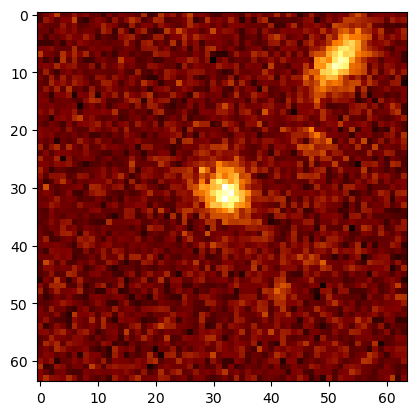

In [4]:
plt.imshow(x_test[29][0], cmap = 'afmhot')

In [5]:
inception = InceptionV3(include_top = False, pooling = 'avg', input_shape = (299, 299, 3))

In [6]:
five_band_images_cvae = np.zeros((5, 2000, 299, 299, 3))

for band in range(5):
    
    # Iterate through bands, and length of image array
    
    for i in tqdm(range(2000)):
        
        resized_image = cv2.resize(x_cvae[i][band], (299, 299))
        stacked_image = np.nan_to_num(np.stack([resized_image] * 3, axis = -1))
        five_band_images_cvae[band][i] = stacked_image

100%|██████████| 2000/2000 [00:01<00:00, 1058.91it/s]


In [7]:
five_band_images_test = np.zeros((5, 2000, 299, 299, 3))

for band in range(5):
    
    # Iterate through bands, and length of image array
    
    for i in tqdm(range(2000)):
        
        resized_image = cv2.resize(x_test[i][band], (299, 299))
        stacked_image = np.nan_to_num(np.stack([resized_image] * 3, axis = -1))
        five_band_images_test[band][i] = stacked_image

100%|██████████| 2000/2000 [00:01<00:00, 1062.37it/s]


In [8]:
five_band_images_val = np.zeros((5, 2000, 299, 299, 3))

for band in range(5):
    
    # Iterate through bands, and length of image array
    
    for i in tqdm(range(2000)):
        
        resized_image = cv2.resize(x_val[i][band], (299, 299))
        stacked_image = np.nan_to_num(np.stack([resized_image] * 3, axis = -1))
        five_band_images_val[band][i] = stacked_image

100%|██████████| 2000/2000 [00:03<00:00, 519.38it/s]


In [9]:
def calculate_inception_score(images, inception_model):
    
    # Get predictions for the images
    preds = inception_model.predict(images)
    
    # For numerical stability, subtract the maximum value from predictions
    preds = preds - np.max(preds, axis=1, keepdims=True)
    
    # Compute the probabilities using softmax in a numerically stable way
    exp_preds = np.exp(preds)
    sum_exp_preds = np.sum(exp_preds, axis=1, keepdims=True)
    preds = exp_preds / sum_exp_preds
    
    # Add a small constant epsilon to avoid log(0)
    epsilon = 1e-10
    preds = np.clip(preds, epsilon, 1. - epsilon)
    
    # Compute the KL divergence for each image
    mean_preds = np.mean(preds, axis=0)
    kl_divergences = preds * (np.log(preds) - np.log(np.expand_dims(mean_preds, 0)))
    
    # Compute the mean KL divergence
    sum_kl_divergences = np.sum(kl_divergences, axis=1)
    avg_kl_divergence = np.mean(sum_kl_divergences)
    
    # Compute the inception score
    inception_score = np.exp(avg_kl_divergence)
    
    return inception_score

In [9]:
def calculate_inception_score_five_band(images, inception_model):
    
    # Get predictions for the images
    
    total_score = 0
    
    for i in range(0, 5):
    
        # Get predictions for the images
        preds = inception_model.predict(images[i])
    
        # For numerical stability, subtract the maximum value from predictions
        preds = preds - np.max(preds, axis = 1, keepdims = True)
    
        # Compute the probabilities using softmax in a numerically stable way
        exp_preds = np.exp(preds)
        sum_exp_preds = np.sum(exp_preds, axis = 1, keepdims = True)
        preds = exp_preds / sum_exp_preds
    
        # Add a small constant epsilon to avoid log(0)
        epsilon = 1e-10
        preds = np.clip(preds, epsilon, 1. - epsilon)
    
        # Compute the KL divergence for each image
        mean_preds = np.mean(preds, axis = 0)
        kl_divergences = preds * (np.log(preds) - np.log(np.expand_dims(mean_preds, 0)))
    
        # Compute the mean KL divergence
        sum_kl_divergences = np.sum(kl_divergences, axis = 1)
        avg_kl_divergence = np.mean(sum_kl_divergences)
    
        # Compute the inception score
        inception_score = np.exp(avg_kl_divergence)
        
        print(inception_score)
        
        total_score += inception_score / 5
    
    return total_score

In [13]:
calculate_inception_score_five_band(five_band_images_test, inception)

63/63 [==============================] - 2s 25ms/step
1.1738341
63/63 [==============================] - 2s 25ms/step
1.5232509
63/63 [==============================] - 2s 25ms/step
1.8744445
63/63 [==============================] - 2s 25ms/step
1.9732213
63/63 [==============================] - 2s 25ms/step
2.0629294


1.7215360403060913

In [11]:
calculate_inception_score_five_band(five_band_images_val, inception)

63/63 [==============================] - 2s 25ms/step
1.1922252
63/63 [==============================] - 2s 25ms/step
1.508336
63/63 [==============================] - 2s 25ms/step
1.854462
63/63 [==============================] - 2s 25ms/step
1.9727914
63/63 [==============================] - 2s 25ms/step
2.0719173


1.7199463844299316

In [10]:
calculate_inception_score_five_band(five_band_images_cvae, inception)

2023-10-17 19:28:36.451347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-17 19:28:37.360844: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-17 19:28:37.580737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 [==============================] - 7s 34ms/step
1.2063245
63/63 [==============================] - 2s 25ms/step
1.3602586
63/63 [==============================] - 2s 25ms/step
1.6662041
63/63 [==============================] - 2s 25ms/step
1.7182252
63/63 [==============================] - 2s 25ms/step
1.7817332


1.546549105644226

In [14]:
from scipy.linalg import sqrtm

def calculate_fid(real_features, generated_features):
    mu1, sigma1 = real_features.mean(axis = 0), np.cov(real_features, rowvar = False)
    mu2, sigma2 = generated_features.mean(axis = 0), np.cov(generated_features, rowvar = False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Calculate feature vectors for real and generated images
test_features = inception.predict(five_band_images_test[0])
cvae_features = inception.predict(five_band_images_cvae[0])
val_features = inception.predict(five_band_images_val[0])

fid_score_cvae = calculate_fid(test_features, cvae_features)
fid_score_val = calculate_fid(test_features, val_features)

print(fid_score_cvae)
print(fid_score_val)

63/63 [==============================] - 2s 25ms/step
126.39901199911651
11.007508656460097


In [ ]:
five_band_images.shape

In [ ]:
inception_scores = np.array([])

for i in range(1): 
    
    resized_g_image = np.expand_dims(cv2.resize(x_cvae[i][0], (299, 299)), axis = 0)
    resized_r_image = np.expand_dims(cv2.resize(x_cvae[i][1], (299, 299)), axis = 0)
    resized_i_image = np.expand_dims(cv2.resize(x_cvae[i][2], (299, 299)), axis = 0)
    resized_z_image = np.expand_dims(cv2.resize(x_cvae[i][3], (299, 299)), axis = 0)
    resized_y_image = np.expand_dims(cv2.resize(x_cvae[i][4], (299, 299)), axis = 0)
    
    plt.imshow(resized_g_image[0])
    
    stacked_g_image = np.expand_dims(np.transpose(np.vstack([resized_g_image, resized_g_image, resized_g_image]), (1, 2, 0)), axis = 0)
    stacked_r_image = np.expand_dims(np.transpose(np.vstack([resized_r_image, resized_r_image, resized_r_image]), (1, 2, 0)), axis = 0)
    stacked_i_image = np.expand_dims(np.transpose(np.vstack([resized_i_image, resized_i_image, resized_i_image]), (1, 2, 0)), axis = 0)
    stacked_z_image = np.expand_dims(np.transpose(np.vstack([resized_z_image, resized_z_image, resized_z_image]), (1, 2, 0)), axis = 0)
    stacked_y_image = np.expand_dims(np.transpose(np.vstack([resized_y_image, resized_y_image, resized_y_image]), (1, 2, 0)), axis = 0)
    
    # print(stacked_g_image.shape)
    
    inception_score_g = calculate_inception_score(stacked_g_image)
    inception_score_r = calculate_inception_score(stacked_r_image)
    inception_score_i = calculate_inception_score(stacked_i_image)
    inception_score_z = calculate_inception_score(stacked_z_image)
    inception_score_y = calculate_inception_score(stacked_y_image)
    
    inception_score = (inception_score_g + inception_score_r + inception_score_i + inception_score_z + inception_score_y) / 5
    
    inception_scores = np.append(inception_scores, inception_score)

In [ ]:
inception_scores = np.array([])

for i in range(len(hf_cvae)): 
    
    resized_g_image = np.expand_dims(cv2.resize(x_cvae[i][0], (299, 299)), axis = 0)
    resized_r_image = np.expand_dims(cv2.resize(x_cvae[i][1], (299, 299)), axis = 0)
    resized_i_image = np.expand_dims(cv2.resize(x_cvae[i][2], (299, 299)), axis = 0)
    resized_z_image = np.expand_dims(cv2.resize(x_cvae[i][3], (299, 299)), axis = 0)
    resized_y_image = np.expand_dims(cv2.resize(x_cvae[i][4], (299, 299)), axis = 0)
    
    stacked_g_image = np.expand_dims(np.transpose(resized_g_image, (1, 2, 0)), axis = 0)
    stacked_r_image = np.expand_dims(np.transpose(resized_r_image, (1, 2, 0)), axis = 0)
    stacked_i_image = np.expand_dims(np.transpose(resized_i_image, (1, 2, 0)), axis = 0)
    stacked_z_image = np.expand_dims(np.transpose(resized_z_image, (1, 2, 0)), axis = 0)
    stacked_y_image = np.expand_dims(np.transpose(resized_y_image, (1, 2, 0)), axis = 0)
    
    # print(stacked_g_image.shape)
    
    inception_score_g = inception_score(stacked_g_image, inception)
    inception_score_r = inception_score(stacked_r_image, inception)
    inception_score_i = inception_score(stacked_i_image, inception)
    inception_score_z = inception_score(stacked_z_image, inception)
    inception_score_y = inception_score(stacked_y_image, inception)
    
    inception_score = (inception_score_g + inception_score_r + inception_score_i + inception_score_z + inception_score_y) / 5
    
    np.append([inception_scores, inception_score])